## Enhanced Model Development and Interrogation using the AITIA Library

**Introduction**

This Jupyter notebook focuses on leveraging the AITIA library to enhance the development and interrogation of machine learning models applied to a dataset comprising military patients who underwent corrective surgery for Chronic Exertional Compartment Syndrome (CECS). The primary predictive target is whether patients return to a fully deployable status within 12 months post-surgery.

The notebook will demonstrate 5 uses for the AITIA library, namely: 

1. A competency analysis to identify and assess the competency of various machine learning models to determine the most suitable candidates for testing and tuning.
2. A concept drift analysis to investigate the resilience of candidate models to potential changes in dataset complexity.
3. Uncertainty explanation to understand why certain patients are more complex than others.
4. Implementation of uncertainty-based abstention as a safeguard mechanism using uncertainty measures to prevent AI usage on patients where model certainty is low.
5. A misclassification analysis to identify patterns and commonalities contributing to remaining errors.

### Set up

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [52]:
models = [LogisticRegression(class_weight='balanced',C=0.25,penalty='l2',solver='liblinear'),
          SVC(probability=True, max_iter=100,class_weight='balanced',C=0.45,gamma='scale',kernel='linear'),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', KNeighborsClassifier(metric='manhattan',weights='uniform',n_neighbors=11,algorithm='brute'))]),
          RandomForestClassifier(class_weight='balanced',max_features='sqrt',n_estimators=20,max_depth=3,warm_start=True),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', AdaBoostClassifier())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', GaussianNB())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', LinearDiscriminantAnalysis())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', QuadraticDiscriminantAnalysis())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', MLPClassifier(max_iter=50))]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=20,booster='gblinear'))])]

model_names = ['Logistic Regression',
               'SVM',
               'KNN',
               'Random Forest',
               'Adaboost',
               'Naive Bayes',
               'Linear Discriminant Analysis',
               'Quadratic Discriminant Analysis',
               'Neural Network',
               'XGBoost']

In [4]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [5]:
feature_names =  ['age', 'rank', 'height', 'weight', 'bmi', 'bp_s', 'bp_d', 'bp', 'map', 'smoker', 'alcohol', 'faam', 'eilp', 'chronicity', 'ttp', 'ttd', 'ttt', 'wait time', 'time_dg', 'co_morb', 'prior_injuries', 'prior_surgery', 'prior_courses']

X = pd.read_csv('data//X.csv',header=None)
X.columns = feature_names
y = pd.read_csv('data//y.csv',header=None)
y.columns = ['labels']

X_ = X[['height', 'map', 'eilp', 'ttt', 'time_dg', 'prior_surgery']]

### Competency Analysis

In [6]:
from interrogation_analysis import CompetencyAnalysis
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
competency_analyser = CompetencyAnalysis(n_datasets=100, pop_size=20, n_gen=10)
competency_analyser.prepare_analysis(X_.values,y['labels'].values)

In [47]:
def compare_models(grid, x_coords, y_coords):
    titles = ['Top Ranked Model', '2nd Ranked Model', '3rd Ranked Model']

    # Set the size of the figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Define a custom color map with 10 colors
    colors = sns.color_palette("pastel", 10)

    # Loop through the top 3 ranked models
    for rank in range(3):
        # Get indices for the current rank
        indices = np.argsort(grid, axis=2)[:, :, -rank - 1]

        # Flatten the coordinates and sorted indices
        x_flattened = x_coords.flatten()
        y_flattened = y_coords.flatten()
        indices_flattened = indices.flatten()
        c = [colors[i] for i in indices_flattened]

        # Create a scatter plot for the current rank using Seaborn
        sns.scatterplot(x=x_flattened, y=y_flattened, c=c, marker='o', ax=axes[rank])
        axes[rank].scatter(competency_analyser.f1_score, competency_analyser.n1_score, color='red', edgecolors='k', linewidths=1, marker='s', s=50, label='Original Specification')

        # Remove color legend from the Seaborn plot
        axes[rank].set_title(titles[rank])
        axes[rank].set_xlabel('F1 Score')
        axes[rank].set_ylabel('N1 Score')
        axes[rank].set_ylim(y_coords[0][0], y_coords[-1][-1])
        axes[rank].set_xlim(x_coords[0][0], x_coords[-1][-1])

    # Create a legend for the models and original specification
    legend_handles = []
    legend_labels = []
    for i, model in enumerate(model_names):
        legend_handles.append(plt.scatter([0], [0], marker='o', c=colors[i], label=model))
        legend_labels.append(model)

    # Add the legend to the figure
    legend_handles.append(plt.scatter([0], [0], marker='s', edgecolors='k', linewidths=1, s=50, color='red', label='Original Specification'))
    legend_labels.append('Original Specification')
    fig.legend(handles=legend_handles, labels=legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

-- Evaluating Logistic Regression --
-- Evaluating SVM --
-- Evaluating KNN --
-- Evaluating Random Forest --
-- Evaluating Adaboost --
-- Evaluating Naive Bayes --
-- Evaluating Linear Discriminant Analysis --
-- Evaluating Quadratic Discriminant Analysis --
-- Evaluating Neural Network --
-- Evaluating XGBoost --


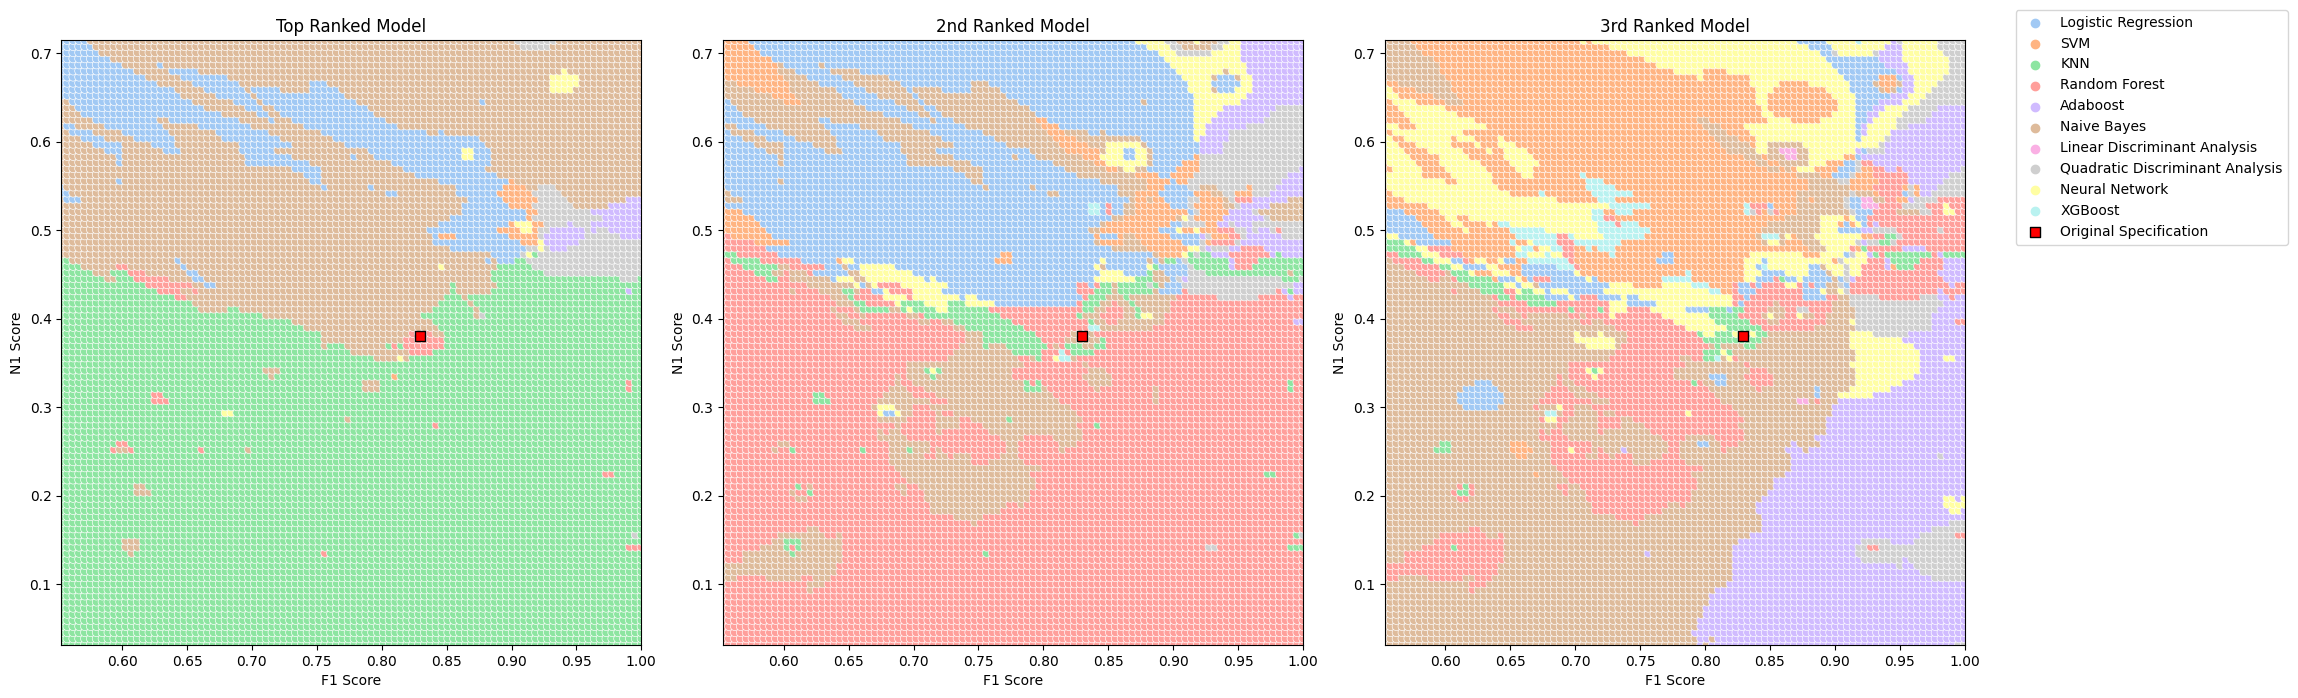

In [56]:
results = {}
for model_name, model in zip(model_names, models):
    print(f'-- Evaluating {model_name} --')
    results[model_name] = {}
    competency_analyser.evaluate_competency(model=model)
    results[model_name]['scores'] = [{'F1': v['F1'], 'N1': v['N1'], 'score': v['score']} for v in competency_analyser.datasets.values()]
    
    # Extract F1, N1, and scores from the datasets
    f1_scores = [v['F1'] for v in competency_analyser.datasets.values()]
    n1_scores = [v['N1'] for v in competency_analyser.datasets.values()]
    scores = [v['score'] for v in competency_analyser.datasets.values()]

    f1_scores_ = []
    n1_scores_ = []
    scores_ = []
    for f1, n1, score in zip(f1_scores, n1_scores, scores):
        if not (np.isnan(f1) or np.isnan(n1) or np.isnan(score)).any():
            f1_scores_.append(f1)
            n1_scores_.append(n1)
            scores_.append(score)

    # Set up a grid for the heatmap
    f1_range = np.linspace(min(f1_scores), max(f1_scores), 100)
    n1_range = np.linspace(min(n1_scores), max(n1_scores), 100)
    f1_mesh, n1_mesh = np.meshgrid(f1_range, n1_range)

    # Use k-nearest neighbors regression to predict accuracy at each grid point
    knn_regressor = KNeighborsRegressor(n_neighbors=20, weights='distance')
    knn_regressor.fit(np.column_stack((f1_scores_, n1_scores_)), scores_)

    # Predict the score at each grid point
    score_grid = knn_regressor.predict(np.column_stack((f1_mesh.ravel(), n1_mesh.ravel())))

    # Reshape the predicted score to the shape of the meshgrid
    score_grid = score_grid.reshape(f1_mesh.shape)
    results[model_name]['score_grid'] = score_grid

grid = np.zeros((100,100,10))
for i, k in enumerate(results.keys()):
    grid[:,:,i] = results[k]['score_grid']

compare_models(grid, f1_mesh, n1_mesh)